In [14]:
%config Completer.use_jedi = False

In [2]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES']='3'
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'

In [3]:
import albumentations as A
from albumentations.core.bbox_utils import normalize_bboxes
from dataclasses import dataclass

import json
import shutil
from tqdm.notebook import tqdm
import yaml
import numpy as np
import glob, gc
import cv2
import staintools
import spams

import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import pycocotools
import pycocotools.mask as mask_util
from pycocotools import _mask as coco_mask

import ultralytics
from ultralytics import YOLO, SAM
from ultralytics.yolo.utils.ops import scale_boxes, scale_coords, scale_image, non_max_suppression
from ultralytics.nn.tasks import attempt_load_weights
from ultralytics.yolo.v8.segment import SegmentationPredictor
from ultralytics.yolo.utils import IterableSimpleNamespace, DEFAULT_CFG_KEYS, DEFAULT_CFG_DICT, DEFAULT_CFG
from copy import deepcopy
ultralytics.checks()


Ultralytics YOLOv8.0.120 🚀 Python-3.9.17 torch-2.0.1+cu117 CUDA:0 (NVIDIA A100 80GB PCIe, 81251MiB)
Setup complete ✅ (64 CPUs, 376.5 GB RAM, 750.6/915.6 GB disk)


In [4]:
def set_seed(seed=42):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# Meta data

In [5]:
meta = pd.read_csv('../data/tile_meta.csv', index_col='id')

meta.dataset.value_counts()

rows = []
with open(f'../data/cleaned_polygons.jsonl', 'r') as json_file:
    for line in json_file:
        data = json.loads(line)
        row = dict({'id': data['id']})
        coords = []
        for ann in data['annotations']:
            if ann['type'] == 'blood_vessel':
                coords.append(ann['coordinates'])
        row['annotation'] = coords
        rows.append(row)
df = pd.DataFrame(rows)
df = df.merge(meta, on='id')
df['num_cells'] = df['annotation'].apply(lambda x: len(x))

df["area"] = df["annotation"].apply(lambda xs: sum([cv2.contourArea(np.array(x)) for x in xs])/512**2) # You might need a different function to calculate the area depending on the structure of annotation
df = df.set_index('id')

In [6]:
# df = pd.read_csv('../data/tile_meta.csv', index_col='id')

# utils

In [7]:
def imshow(mask):
    fig = plt.figure()
    if len(mask.shape) == 3:
        plt.imshow(np.any(mask.astype(bool), 0))
    else:
        plt.imshow(mask)
    plt.plot()

In [8]:
# !pip install --no-index \
# /kaggle/input/wbf-download-code-for-offline-installation/Weighted-Boxes-Fusion/ensemble_boxes-1.0.7-py3-none-any.whl \
# --find-links=/kaggle/input/wbf-download-code-for-offline-installation/Weighted-Boxes-Fusion

In [9]:
# !pip install ensemble-boxes

In [10]:
from skimage import draw
def make_masks(annotations, size=(512, 512)):
    masks = []
    for annot in annotations:
        mask = np.zeros(size, dtype=np.float32)
        cords = annot['coordinates']
        if annot['type'] == "blood_vessel":
            for cord in cords:
                rr, cc = np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord])
                rr, cc = draw.polygon(rr, cc)
                mask[rr, cc] = 1
            masks.append(mask)
    if len(masks) == 0:
        masks.append(np.zeros(size, dtype=np.float32))
    return np.stack(masks)

In [11]:
def parse_ann(annotations):
    target = []
    for annot in annotations:
        if annot['type'] == "blood_vessel":
            target.append(np.array(annot['coordinates']).flatten().tolist())
    return target

# evaluation

In [12]:
from metrics import MAPCalculatorSingleClass

In [13]:
with open('../data/cleaned_polygons.jsonl', 'r') as json_file:
    json_labels = [json.loads(line) for line in json_file]
id_to_annotation = {j['id']: j['annotations'] for j in json_labels}

In [15]:
DATA_BASE = 'dataset'
BASE_FILENAME = '../data/'

In [16]:
def evaluate_model(annotations, prediction_masks, predicition_scores):
    mAP_calc = MAPCalculatorSingleClass()
    height, width = (512, 512)
    ious = [] 
    for ann, pred_masks, scores in zip(annotations, prediction_masks, predicition_scores):
        if len(ann) == 0:
            ious.append(len(scores) == 0)
            continue
        enc_gt = coco_mask.frPyObjects(ann, height, width)
        num_gts = len(enc_gt)
        enc_pred = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
        
        _ious = mask_util.iou(enc_pred, enc_gt, [0]*len(enc_gt))
        mAP_calc.accumulate(_ious, scores, num_gts)
        score = mAP_calc.evaluate()[0]
        ious.append(score)
    return ious

# inference

In [17]:
def predict(
    image, # image in bgr
    models,
    transforms=[None],
    imgsz=512,
    conf=0.01,
    iou_nms=0.5,
    retina_masks=True,
):
    boxes, masks, scores = [], [], []

    og_img = np.array(image.copy()).astype(np.uint8)
    h, w = og_img.shape[:2]

    for model in models:
        for transform in transforms:
            if transform is not None:
                img = transform(image=og_img)["image"]
            else:
                img = og_img.copy()

            pred = model.predict(
                img, imgsz=imgsz, conf=conf, iou=iou_nms, retina_masks=retina_masks, verbose=False, 
            )[0]

            if pred.masks is None:
                continue

            pred_masks = pred.masks.data[pred.boxes.cls == 0].detach().cpu().numpy()

            if len(pred_masks) == 0:
                continue
            pred_confs = pred.boxes.conf[pred.boxes.cls == 0].detach().cpu().numpy()
            pred_boxes = pred.boxes.xyxyn[pred.boxes.cls == 0].detach().cpu().numpy()

            if transform is not None:
                out = transform(image=img, bboxes=pred_boxes, masks=pred_masks)
                pred_boxes = out["bboxes"]
                pred_masks  = out["masks"]

            boxes.append(np.array(pred_boxes))
            masks.append(pred_masks)
            scores.append(np.array(pred_confs))
            del pred, pred_boxes, pred_masks, img
    del og_img
    if len(boxes) == 0:
        return np.array([]), np.array([]), np.array([])
    boxes, masks, scores = np.concatenate(boxes), np.concatenate(masks).astype(np.uint8), np.concatenate(scores)
#     boxes = np.concatenate((boxes, scores[:, None]), axis=1) # add scores to boxes
    
    return masks, boxes, scores

# Ensembling

In [18]:
def combine_results_nmms(masks, boxes, scores, iou_nms=0.5):
    """
    NMS with masks.
    Removes more masks than the tweaking fct.

    Args:
        masks ([type]): [description]
        boxes ([type]): [description]
        iou_nms (float, optional): [description]. Defaults to 0.5.

    Returns:
        [type]: [description]
    """
    # assert list(np.argsort(boxes[:, 4])[::-1]) == list(range(len(boxes)))
    order = np.argsort(scores)[::-1]
    masks = masks[order]
    boxes = boxes[order]

    rle_pred = [pycocotools.mask.encode(np.asarray(m, order='F')) for m in masks]
    ious = pycocotools.mask.iou(rle_pred, rle_pred, [0] * len(rle_pred))

    picks = []
    idxs = list(range(len(ious)))
    # removed = []

    while len(idxs) > 0:
        idx = idxs[0]
        overlapping = np.where(ious[idx] > iou_nms)[0]

        # removed += [v for v in overlapping if v > idx]

        if len(overlapping):
            picks.append(idx)
            idxs = [i for i in idxs if i not in overlapping]
        else:
            idxs = idxs[1:]

    masks = masks[picks]
    boxes = boxes[picks]
    return masks, boxes, scores[picks]

In [19]:
sys.path.append('../src')
from wbf_tracking import weighted_boxes_fusion_tracking as wbf_tracking

def bbox_to_key(bbox):
    return ','.join(map(str, np.round(bbox, 4)))
    

def combine_results_wbf(masks, boxes, scores, iou_thr=0.55, skip_box_thr=0.0, label_thr=0, min_votes=2, cut_by_box=False, weights=None):
    bbox_to_idx = {}
    h, w = masks.shape[-2:]
    
    for i, (mask, box) in enumerate(zip(masks, boxes)):
        bbox_to_idx[bbox_to_key(box)] = i
    
    labels = np.ones(len(boxes))  
    wbf_boxes, _, _, wbf_ogs = wbf_tracking(
        [boxes],
        [scores],
        labels_list=[labels],
        iou_thr=iou_thr,
        skip_box_thr=skip_box_thr,
        weights=weights,
    )

    wbf_masks, wbf_scores = [], []
    for i, wbf_box in enumerate(wbf_boxes):
        
        if cut_by_box:
            filter_box = np.zeros((h, w), dtype=np.uint8)

            x1 = max(0, int(h * wbf_box[0]))
            y1 = max(0, int(w * wbf_box[1]))
            x2 = min(h, int(h * wbf_box[2]))
            y2 = min(w, int(w * wbf_box[3]))
            filter_box[y1:y2, x1:x2] = 1
        
        keep = []
        skiped = 0
        for og_box in wbf_ogs[i]:
            key = bbox_to_key(og_box[4:])
            if key in bbox_to_idx:
                keep.append(bbox_to_idx[key])
            else:
                skiped += 1
                continue
        if len(keep) < min_votes-skiped:
            wbf_mask = np.zeros((h, w), dtype=np.uint8)
            wbf_score = 0
        else:
            wbf_mask = (np.mean(masks[keep], axis=0) > label_thr).astype(bool)
            if cut_by_box:
                wbf_mask = wbf_mask & filter_box # remove pixels outside wbf
            wbf_score = np.mean(scores[keep])

        wbf_masks.append(wbf_mask)
        wbf_scores.append(wbf_score)
    
    wbf_masks = np.stack(wbf_masks)
    wbf_scores = np.array(wbf_scores) 
    return wbf_masks, wbf_boxes, wbf_scores

# Postprocessing

In [20]:
from skimage.morphology import binary_dilation

In [21]:
def remove_overlap_naive(masks, ious=None):
    if ious is None:
        rles = [pycocotools.mask.encode(np.asarray(m, order='F')) for m in masks]
        ious = pycocotools.mask.iou(rles, rles, [0] * len(rles))

    if not len(ious):
        return masks
    
    for i in range(len(ious)):
        ious[i, i] = 0
    to_process = np.where(ious.sum(0) > 0)[0]

    if not len(to_process):
        return masks

    masks = torch.from_numpy(masks).cuda()
    overlapping_masks = masks[to_process]

    for idx, i in enumerate(to_process):
        if idx == 0:
            continue
        others = overlapping_masks[:idx].max(0)[0]
        masks[i] *= ~others

    return masks.cpu().numpy()

In [22]:
def remove_small_masks(masks, boxes, min_size=0):
    if min_size == 0 or len(masks) == 0:
        return masks, boxes

    sizes = masks.sum(-1).sum(-1) / 512**2
    to_keep = sizes > min_size

    if to_keep.min() == 1:
        return masks, boxes

    smallest = sizes.min()
    to_keep = sizes > smallest

    return masks[to_keep], boxes[to_keep]

In [23]:
def degrade_mask(mask):
    cont, hier = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    img_cont = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    img_cont = cv2.drawContours(img_cont, cont, -1, (255, 255, 255), 1)
    img_cont = img_cont[:, :, 0]

    conv_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for c in cont:
        conv_mask = cv2.fillConvexPoly(conv_mask, points=c, color=(1, 1, 1))
    conv_mask = conv_mask[:, :, 0].astype(mask.dtype)

    return conv_mask, img_cont

In [24]:
def postprocess_masks(masks, boxes,
                      conf_thresh=0,
                      min_size=0,
                      dilation_n_iter=1,
                      remove_overlap=True,
                      corrupt=False,
                     ):

    # Sort by decreasing conf
    order = np.argsort(boxes[:, 4])[::-1]
    masks = masks[order]
    boxes = boxes[order]

    # Remove low confidence
    last = (
        np.argmax(boxes[:, 4] < conf_thresh) if np.min(boxes[:, 4]) < conf_thresh
        else len(boxes)
    )
    masks = masks[:last]
    boxes = boxes[:last]

    # Remove small masks
    if min_size:
        masks, boxes = remove_small_masks(masks, boxes, min_size=min_size)
       
    # Corrupt
    if corrupt:
        masks = np.array([degrade_mask(mask)[0] for mask in masks])

    # Remove overlap
    if remove_overlap:
        masks = remove_overlap_naive(masks)
    
    # Dilate
    if dilation_n_iter != 0:
        for i in range(len(masks)):
            for _ in range(dilation_n_iter):
                masks[i] = binary_dilation(masks[i])

    return masks, boxes

In [25]:
# model = YOLO('HuBMAP/mskf_yolov8x-seg-fold0/weights/best.pt')

In [26]:
# for image_id in ids[:5]:
#     image = Image.open(os.path.join('../data/train/' ,image_id+'.tif'))
#     gt_mask = make_masks(id_to_annotation[image_id])
#     imshow(gt_mask)
#     pred = model(image, conf=0.01, iou=0.5)[0]
#     plt.figure()
#     plt.imshow(pred.plot())

In [32]:
# FOLDS_ROOT = 'ds1_only/'
FOLDS_ROOT = 'mskf_folds/'
# FOLDS_ROOT = 'loo_stained_wsi/'
PROJECT = 'HuBMAP'
MODEL_V = 'yolov8x-seg'
PREFIX = 'mskf_v3_'

In [34]:
folds_i = [0, 1, 2, 3, 4]
models = [
    YOLO(f'{PROJECT}/{PREFIX}{MODEL_V}-fold{i}/weights/best.pt')
    for i in folds_i

]

In [35]:
metrics = []
for model in models:
    metrics.append(model.val(conf=0.2, iou=0.5))

Ultralytics YOLOv8.0.120 🚀 Python-3.9.17 torch-2.0.1+cu117 CUDA:0 (NVIDIA A100 80GB PCIe, 81251MiB)
YOLOv8x-seg summary (fused): 295 layers, 71721619 parameters, 0 gradients
val: Scanning /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/mskf_folds/fold0/valid.cache... 326 images, 1 backgrounds, 0 corrupt: 10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|███
                   all        326       3050      0.723      0.685      0.738      0.429      0.735      0.697      0.751      0.408
Speed: 0.7ms preprocess, 8.5ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/val117
Ultralytics YOLOv8.0.120 🚀 Python-3.9.17 torch-2.0.1+cu117 CUDA:0 (NVIDIA A100 80GB PCIe, 81251MiB)
YOLOv8x-seg summary (fused): 295 layers, 71721619 parameters, 0 gradients
val: Scanning /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/mskf_folds/fold1/valid.cache... 327 images, 

In [ ]:
# conf = 0.2
# 0.5383596117385798
# 0.35274882668783597
# 0.6031901631314784
# 0.465530342172658
# mean: 0.48995723593263807

In [56]:
# conf = 0.01
# 0.5188844193116329
# 0.3021399976875739
# 0.5858309691365907
# 0.459609977905004

In [41]:
np.mean(ious)

0.46661634101020033

In [28]:
def luminos_standardize(I, percentile=95):
    """
    I: image in BGR
    """
    I_LAB = cv2.cvtColor(I, cv2.COLOR_BGR2LAB)
    L_float = I_LAB[:, :, 0].astype(float)
    p = np.percentile(L_float, percentile)
    I_LAB[:, :, 0] = np.clip(255 * L_float / p, 0, 255).astype(np.uint8)
    I = cv2.cvtColor(I_LAB, cv2.COLOR_LAB2BGR)
    return I

In [29]:
from tqdm.notebook import tqdm_notebook as tqdm

In [64]:
@dataclass
class CFG:
    # inference
    conf: float = 0.01
    imgsz: int = (512, 512)
    retina_masks: bool = True
    iou_nms: float = 0.5
#     transforms: tuple = (None,)
    transforms: tuple = (None, A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0), A.Rotate(limit=(180,180), p=1.0))
        
    
    # ensemble
    method: str = 'wbf' # 'nms' or 'wbf'
    iou_ensemble: float = 0.5

    wbf_min_votes: int = 1
    wbf_label_thr: float = 0.1
    wbf_cut_by_box: bool = 1
    # postproccess
    conf_thresh: float = 0.0
    min_size: float = 0.001
    dilation_n_iter: int = 1
    remove_overlap: bool = False
    corrupt: bool = False
        

    def __repr__(self):
        params = '\n'.join(f'{k}={v}' for k, v in self.__dict__.items())
        return params

In [ ]:
# FOLDS_ROOT = 'ds1_only/'
FOLDS_ROOT = 'mskf_folds/'
# FOLDS_ROOT = 'loo_stained_wsi/'
PROJECT = 'HuBMAP'
MODEL_V = 'yolov8x-seg'
PREFIX = 'mskf_v3_'

print(FOLDS_ROOT + '  ' + PREFIX)
print(CFG())
print()

oof = []
folds_i = [0, 1, 2, 3]

for i in folds_i:
    models = [
        YOLO(f'{PROJECT}/{PREFIX}{MODEL_V}-fold{i}/weights/best.pt'),
        
    ]
    

    val_dir = f'{FOLDS_ROOT}/fold{i}/valid/'
    val_ids = [r.split('.')[0] for r in os.listdir(val_dir) if r.endswith('.txt')]

    annotations = []
    pred_masks = []
    pred_scores = []
    for image_id in tqdm(val_ids):
        annotations.append(parse_ann(id_to_annotation[image_id]))
        image = cv2.imread(os.path.join(val_dir, image_id + '.tif'))
        
#         image = luminos_standardize(image)
#         image = staintools.LuminosityStandardizer.standardize(image) # only on test inference
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        raw_masks, raw_boxes, raw_scores = predict(
            image=image,
            models=models,
            transforms=CFG.transforms,
            imgsz=CFG.imgsz,
            conf=CFG.conf,
            iou_nms=CFG.iou_nms,
            retina_masks=CFG.retina_masks
        )

        if len(raw_boxes):
            if CFG.method == 'wbf':
                masks, boxes, scores = combine_results_wbf(
                    raw_masks, raw_boxes, raw_scores,
                    iou_thr=CFG.iou_ensemble,
                    min_votes=CFG.wbf_min_votes, 
                    label_thr=CFG.wbf_label_thr,
                    cut_by_box=CFG.wbf_cut_by_box,                    
                )
            elif CFG.method == 'nms':
                masks, boxes, scores = combine_results_nmms(
                    raw_masks, raw_boxes,
                    raw_scores, iou_nms=CFG.iou_ensemble
                )
            else:
                masks, boxes, scores = raw_masks, raw_boxes, raw_scores
        else:
            masks, boxes, scores = raw_masks, raw_boxes, raw_scores

        if len(boxes):
            boxes = np.concatenate((boxes, scores[:, None]), axis=1)  # add conf to boxes
            masks, boxes = postprocess_masks(
                masks,
                boxes,
                conf_thresh=CFG.conf_thresh,
                min_size=CFG.min_size,
                dilation_n_iter=CFG.dilation_n_iter,
                remove_overlap=CFG.remove_overlap,
                corrupt=CFG.corrupt
            )
            scores = boxes[:, 4]
        else:
            masks = np.zeros((1, 512, 512), dtype=np.uint8)
            scores = np.array([0])

        pred_masks.append(masks)
        pred_scores.append(scores)

    ious = evaluate_model(annotations, pred_masks, pred_scores)
    print(f'fold {i}')
    print(f'IOU mean: {np.mean(ious):.4}  std: {np.std(ious):.4}')
    print()
    result_df = pd.DataFrame(ious, columns=['iou'], index=val_ids)
    result_df['source_wsi'] = df.loc[result_df.index.values]['source_wsi']
    result_df['dataset'] = df.loc[result_df.index.values]['dataset']
    oof.append(result_df)
    

oof = pd.concat(oof)
oof['source_wsi'] = oof['source_wsi'].astype('category')
for wsi, subdf in oof.groupby('source_wsi'):
    print(f'wsi {wsi}')
    print(f'IOU mean: {np.mean(subdf.iou.values):.4}  std: {np.std(subdf.iou.values):.4}')
print()
for ds_i, subdf in oof.groupby('dataset'):
    print(f'dataset {ds_i}')
    print(f'IOU mean: {np.mean(subdf.iou.values):.4}  std: {np.std(subdf.iou.values):.4}')
print()
print(f'overall with oof size {len(oof)}')
print(f'IOU mean: {np.mean(oof.iou.values):.4}  std: {np.std(oof.iou.values):.4}')

mskf_folds/  mskf_v3_
conf=0.01
imgsz=(512, 512)
retina_masks=True
iou_nms=0.5
transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
method=wbf
iou_ensemble=0.5
wbf_min_votes=1
wbf_label_thr=0.1
wbf_cut_by_box=1
conf_thresh=0.0
min_size=0.001
dilation_n_iter=1
remove_overlap=False
corrupt=False



  0%|          | 0/326 [00:00<?, ?it/s]

In [ ]:
# wsi 1
# IOU mean: 0.3921  std: 0.06123
# wsi 2
# IOU mean: 0.3663  std: 0.02497
# wsi 3
# IOU mean: 0.5313  std: 0.01838
# wsi 4
# IOU mean: 0.4942  std: 0.03411

# dataset 1
# IOU mean: 0.3834  std: 0.05397
# dataset 2
# IOU mean: 0.4556  std: 0.07893

# overall with oof size 1633
# IOU mean: 0.4369  std: 0.07983

In [ ]:
# loo_stained_wsi/  loo_stained_
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.5
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.5
# wbf_min_votes=0
# wbf_label_thr=0.9
# wbf_cut_by_box=True
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=0
# remove_overlap=False
# corrupt=False

# 100%
# 507/507 [03:38<00:00, 1.51it/s]
# fold 0
# IOU mean: 0.4667  std: 0.07118

# wsi 1
# IOU mean: 0.4667  std: 0.07118

# dataset 1
# IOU mean: 0.4658  std: 0.07203
# dataset 2
# IOU mean: 0.4677  std: 0.07018

# overall with oof size 507
# IOU mean: 0.4667  std: 0.07118

In [ ]:
# loo_stained_wsi/  loo_stained_
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.5
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.9
# wbf_cut_by_box=True
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=0
# remove_overlap=False
# corrupt=False

# fold 0
# IOU mean: 0.4176  std: 0.06419

# wsi 1
# IOU mean: 0.4176  std: 0.06419

# dataset 1
# IOU mean: 0.4169  std: 0.06516
# dataset 2
# IOU mean: 0.4184  std: 0.06304

# overall with oof size 507
# IOU mean: 0.4176  std: 0.06419

In [172]:
image = normalizer.transform(np.array(image))
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

In [174]:
image = staintools.LuminosityStandardizer.standardize(image)

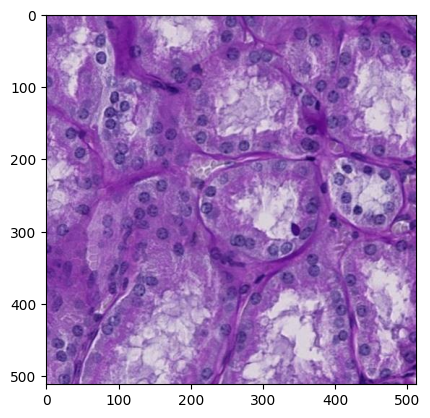

In [169]:
plt.imshow(image)

In [ ]:
# fold 0
# IOU mean: 0.3125  std: 0.113

# wsi 1
# IOU mean: 0.3125  std: 0.113

# dataset 1
# IOU mean: 0.3519  std: 0.0457
# dataset 2
# IOU mean: 0.273  std: 0.1426

# overall with oof size 10
# IOU mean: 0.3125  std: 0.113

In [ ]:
# mskf_folds/  mskf_v3_
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.5
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.95
# wbf_cut_by_box=True
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=0
# remove_overlap=False
# corrupt=False

# fold 0
# IOU mean: 0.6075  std: 0.04953

# fold 1
# IOU mean: 0.5734  std: 0.07303

# fold 2
# IOU mean: 0.6133  std: 0.05113

# wsi 1
# IOU mean: 0.5861  std: 0.1001
# wsi 2
# IOU mean: 0.6033  std: 0.02768
# wsi 3
# IOU mean: 0.6041  std: 0.03335
# wsi 4
# IOU mean: 0.6026  std: 0.02503

# dataset 1
# IOU mean: 0.5897  std: 0.08635
# dataset 2
# IOU mean: 0.6011  std: 0.04901

# overall with oof size 979
# IOU mean: 0.598  std: 0.06148

In [ ]:
# mskf_folds/  mskf_v3_
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.5
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.4
# wbf_cut_by_box=True
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=0
# remove_overlap=False
# corrupt=False

# fold 0
# IOU mean: 0.6226  std: 0.04334

# fold 1
# IOU mean: 0.5951  std: 0.07693

# wsi 1
# IOU mean: 0.5942  std: 0.1061
# wsi 2
# IOU mean: 0.6149  std: 0.02242
# wsi 3
# IOU mean: 0.6155  std: 0.03069
# wsi 4
# IOU mean: 0.6161  std: 0.02519

# dataset 1
# IOU mean: 0.6003  std: 0.09366
# dataset 2
# IOU mean: 0.6119  std: 0.0481

# overall with oof size 653
# IOU mean: 0.6088  std: 0.06396

In [ ]:
# mskf_folds/  mskf_v3_
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.5
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.8
# wbf_cut_by_box=True
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=0
# remove_overlap=False
# corrupt=False

# fold 0
# IOU mean: 0.621  std: 0.05021

# wsi 1
# IOU mean: 0.6158  std: 0.06933
# wsi 2
# IOU mean: 0.6238  std: 0.03457
# wsi 3
# IOU mean: 0.6263  std: 0.04483
# wsi 4
# IOU mean: 0.6183  std: 0.03209

# dataset 1
# IOU mean: 0.614  std: 0.07208
# dataset 2
# IOU mean: 0.6237  std: 0.03841

# overall with oof size 326
# IOU mean: 0.621  std: 0.05021

In [ ]:
# mskf_folds/  mskf_v2_
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.5
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.5
# wbf_min_votes=0
# wbf_label_thr=0.8
# wbf_cut_by_box=True
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.5377  std: 0.09718

# fold 1
# IOU mean: 0.4551  std: 0.1203

# fold 2
# IOU mean: 0.5235  std: 0.103

# fold 3
# IOU mean: 0.4689  std: 0.07314

# fold 4
# IOU mean: 0.5243  std: 0.04564

# wsi 1
# IOU mean: 0.4773  std: 0.1109
# wsi 2
# IOU mean: 0.4906  std: 0.0749
# wsi 3
# IOU mean: 0.5368  std: 0.08864
# wsi 4
# IOU mean: 0.5176  std: 0.09371

# dataset 1
# IOU mean: 0.4832  std: 0.08093
# dataset 2
# IOU mean: 0.5065  std: 0.1006

# overall with oof size 175
# IOU mean: 0.5019  std: 0.09746

In [ ]:
# mskf_folds/  mskf_v2_
# conf=0.01
# imgsz=(640, 640)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.5
# wbf_min_votes=0
# wbf_label_thr=0.95
# wbf_cut_by_box=True
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.5201  std: 0.08971

# fold 1
# IOU mean: 0.4345  std: 0.1018

# fold 2
# IOU mean: 0.5103  std: 0.1047

# fold 3
# IOU mean: 0.4725  std: 0.06099

# fold 4
# IOU mean: 0.5363  std: 0.03548

# wsi 1
# IOU mean: 0.4733  std: 0.108
# wsi 2
# IOU mean: 0.4844  std: 0.07043
# wsi 3
# IOU mean: 0.5269  std: 0.08267
# wsi 4
# IOU mean: 0.5064  std: 0.07337

# dataset 1
# IOU mean: 0.4735  std: 0.07631
# dataset 2
# IOU mean: 0.5001  std: 0.09315

# overall with oof size 175
# IOU mean: 0.4947  std: 0.09066

In [139]:
# mskf_folds/  mskf_v2_
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.6
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.7
# wbf_min_votes=0
# wbf_label_thr=0.95
# wbf_cut_by_box=True
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.548  std: 0.09244

# fold 1
# IOU mean: 0.4828  std: 0.1185

# fold 2
# IOU mean: 0.5301  std: 0.1031

# fold 3
# IOU mean: 0.4697  std: 0.06717

# fold 4
# IOU mean: 0.5428  std: 0.05368

# wsi 1
# IOU mean: 0.4907  std: 0.1122
# wsi 2
# IOU mean: 0.5051  std: 0.0753
# wsi 3
# IOU mean: 0.5481  std: 0.08252
# wsi 4
# IOU mean: 0.5286  std: 0.08885

# dataset 1
# IOU mean: 0.4987  std: 0.08043
# dataset 2
# IOU mean: 0.5187  std: 0.09875

# overall with oof size 175
# IOU mean: 0.5147  std: 0.0957

In [ ]:
# all val
# mskf_folds/  mskf_v2_
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.6
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.7
# wbf_min_votes=0
# wbf_label_thr=0.95
# wbf_cut_by_box=1
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.501  std: 0.04517

# fold 1
# IOU mean: 0.4672  std: 0.06552

# fold 2
# IOU mean: 0.488  std: 0.0478

# fold 3
# IOU mean: 0.5087  std: 0.03991

# fold 4
# IOU mean: 0.5053  std: 0.04792

# wsi 1
# IOU mean: 0.4865  std: 0.07816
# wsi 2
# IOU mean: 0.4947  std: 0.03067
# wsi 3
# IOU mean: 0.5001  std: 0.03653
# wsi 4
# IOU mean: 0.4976  std: 0.03598

# dataset 1
# IOU mean: 0.4875  std: 0.0658
# dataset 2
# IOU mean: 0.4963  std: 0.04643

# overall with oof size 1633
# IOU mean: 0.494  std: 0.05227

In [ ]:
# ds1_only/  ds1_only_
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.6
# wbf_cut_by_box=1
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.6242  std: 0.02808

# fold 1
# IOU mean: 0.6004  std: 0.09847

# fold 2
# IOU mean: 0.5524  std: 0.1074

# fold 3
# IOU mean: 0.577  std: 0.09402

# fold 4
# IOU mean: 0.6005  std: 0.04171

# wsi 1
# IOU mean: 0.5895  std: 0.1024
# wsi 2
# IOU mean: 0.5932  std: 0.034

# dataset 1
# IOU mean: 0.5908  std: 0.08446

# overall with oof size 422
# IOU mean: 0.5908  std: 0.08446

In [ ]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.6
# wbf_cut_by_box=1
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.6242  std: 0.02808

# fold 1
# IOU mean: 0.6004  std: 0.09847

# wsi 1
# IOU mean: 0.6184  std: 0.08677
# wsi 2
# IOU mean: 0.6016  std: 0.03971

# dataset 1
# IOU mean: 0.6122  std: 0.07356

# overall with oof size 169
# IOU mean: 0.6122  std: 0.07356

In [ ]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.6
# wbf_cut_by_box=1
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=0
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.6057  std: 0.04851

# fold 1
# IOU mean: 0.5794  std: 0.1041

# wsi 1
# IOU mean: 0.5998  std: 0.09613
# wsi 2
# IOU mean: 0.5799  std: 0.04804

# dataset 1
# IOU mean: 0.5925  std: 0.08239

# overall with oof size 169
# IOU mean: 0.5925  std: 0.08239

# Pseudolabeling

In [71]:
PROJECT = 'HuBMAP'
MODEL_V = 'yolov8x-seg'
PREFIX = 'mskf_v2_'

In [72]:
models = [
    YOLO(f'{PROJECT}/{PREFIX}{MODEL_V}-fold{i}/weights/best.pt') for i in [0, 1, 2, 3, 4]
]

In [73]:
@dataclass
class CFG:
    # inference
    conf: float = 0.01
    imgsz: int = (512, 512)
    retina_masks: bool = True
    iou_nms: float = 0.4
#     transforms: tuple = (None,)
    transforms: tuple = (None, A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0), A.Rotate(limit=(180,180), p=1.0))
        
#     transforms: tuple = (None, A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0), A.Rotate(limit=(180,180), p=1.0))
    #  A.Rotate(limit=(180,180), p=1.0)
    
    # ensemble
    method: str = 'wbf' # 'nms' or 'wbf'
    iou_ensemble: float = 0.4

    wbf_min_votes: int = 0
    wbf_label_thr: float = 0.6
    wbf_cut_by_box: bool = 1
    # postproccess
    conf_thresh: float = 0.0
    min_size: float = 0.001
    dilation_n_iter: int = 1
    remove_overlap: bool = True
    corrupt: bool = False

In [ ]:
# Pseudolabeling

folds_i = [0, 1, 2, 3, 4]
for i in folds_i:
    val_dir = f'{FOLDS_ROOT}/fold{i}/valid/'
    val_ids = [r.split('.')[0] for r in os.listdir(val_dir) if r.endswith('.txt')]

    annotations = []
    pred_masks = []
    pred_scores = []
    for image_id in val_ids:
        annotations.append(parse_ann(id_to_annotation[image_id]))
        image = Image.open(os.path.join(val_dir, image_id + '.tif'))

        raw_masks, raw_boxes, raw_scores = predict(
            image=image,
            models=models,
            transforms=CFG.transforms,
            imgsz=CFG.imgsz,
            conf=CFG.conf,
            iou_nms=CFG.iou_nms,
            retina_masks=CFG.retina_masks
        )

        if len(raw_boxes):
            if CFG.method == 'wbf':
                masks, boxes, scores = combine_results_wbf(
                    raw_masks, raw_boxes, raw_scores,
                    iou_thr=CFG.iou_ensemble,
                    min_votes=CFG.wbf_min_votes, 
                    label_thr=CFG.wbf_label_thr,
                    cut_by_box=CFG.wbf_cut_by_box,                    
                )
            elif CFG.method == 'nms':
                masks, boxes, scores = combine_results_nmms(
                    raw_masks, raw_boxes,
                    raw_scores, iou_nms=CFG.iou_ensemble
                )
            else:
                masks, boxes, scores = raw_masks, raw_boxes, raw_scores
        else:
            masks, boxes, scores = raw_masks, raw_boxes, raw_scores

        if len(boxes):
            boxes = np.concatenate((boxes, scores[:, None]), axis=1)  # add conf to boxes
            masks, boxes = postprocess_masks(
                masks,
                boxes,
                conf_thresh=CFG.conf_thresh,
                min_size=CFG.min_size,
                dilation_n_iter=CFG.dilation_n_iter,
                remove_overlap=CFG.remove_overlap,
                corrupt=CFG.corrupt
            )
            scores = boxes[:, 4]
        else:
            masks = np.zeros((1, 512, 512), dtype=np.uint8)
            scores = np.array([0])
        
        pred_masks.append(masks)
        pred_scores.append(scores)

    ious = evaluate_model(annotations, pred_masks, pred_scores)
    print(f'fold {i}')
    print(f'IOU mean: {np.mean(ious):.4}  std: {np.std(ious):.4}')
    print()
    result_df = pd.DataFrame(ious, columns=['iou'], index=val_ids)
    result_df['source_wsi'] = df.loc[result_df.index.values]['source_wsi']
    result_df['dataset'] = df.loc[result_df.index.values]['dataset']
    oof.append(result_df)


In [ ]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.35
# wbf_cut_by_box=1
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=0
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.5464  std: 0.09881

# fold 1
# IOU mean: 0.4635  std: 0.1164

# fold 2
# IOU mean: 0.4859  std: 0.09427

# fold 3
# IOU mean: 0.4282  std: 0.07589

# fold 4
# IOU mean: 0.5315  std: 0.05797

# wsi 1
# IOU mean: 0.4708  std: 0.1121
# wsi 2
# IOU mean: 0.4794  std: 0.07817
# wsi 3
# IOU mean: 0.5234  std: 0.09532
# wsi 4
# IOU mean: 0.5024  std: 0.1019
# dataset 1
# IOU mean: 0.4794  std: 0.08677
# dataset 2
# IOU mean: 0.494  std: 0.1038
# overall with oof size 175
# IOU mean: 0.4911  std: 0.1008

In [ ]:
# all val
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=1
# wbf_label_thr=0.6
# wbf_cut_by_box=1
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=True

# fold 0
# IOU mean: 0.4799  std: 0.04603

# fold 1
# IOU mean: 0.4298  std: 0.06169

# fold 2
# IOU mean: 0.4759  std: 0.04968

# fold 3
# IOU mean: 0.476  std: 0.04351

# fold 4
# IOU mean: 0.4545  std: 0.04398

# wsi 1
# IOU mean: 0.4561  std: 0.0756
# wsi 2
# IOU mean: 0.4648  std: 0.03622
# wsi 3
# IOU mean: 0.4679  std: 0.03986
# wsi 4
# IOU mean: 0.4666  std: 0.0387
# dataset 1
# IOU mean: 0.4577  std: 0.06515
# dataset 2
# IOU mean: 0.4651  std: 0.04782
# overall with oof size 1633
# IOU mean: 0.4632  std: 0.05295

In [ ]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=1
# wbf_label_thr=0.6
# wbf_cut_by_box=1
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=True

# fold 0
# IOU mean: 0.5255
# IOU std: 0.09586

# fold 1
# IOU mean: 0.4481
# IOU std: 0.1132

# fold 2
# IOU mean: 0.4475
# IOU std: 0.1099

# fold 3
# IOU mean: 0.4433
# IOU std: 0.0724

# fold 4
# IOU mean: 0.5578
# IOU std: 0.0731

# wsi 1
# IOU mean: 0.4572
# IOU std: 0.1204
# wsi 2
# IOU mean: 0.4741
# IOU std: 0.07981
# wsi 3
# IOU mean: 0.5238
# IOU std: 0.1047
# wsi 4
# IOU mean: 0.4971
# IOU std: 0.08969
# overall with 175
# IOU mean: 0.4845
# IOU std: 0.1059

In [145]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=1
# wbf_label_thr=0.6
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=True
# wsi 1
# IOU mean: 0.4391
# IOU std: 0.118
# wsi 2
# IOU mean: 0.4526
# IOU std: 0.08011
# wsi 3
# IOU mean: 0.5028
# IOU std: 0.1092
# wsi 4
# IOU mean: 0.4731
# IOU std: 0.08496
# overall with 175
# IOU mean: 0.4638
# IOU std: 0.1053

In [136]:
# all val
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.7
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.4509
# IOU std: 0.04834

# fold 1
# IOU mean: 0.4175
# IOU std: 0.05879

# fold 2
# IOU mean: 0.4242
# IOU std: 0.0441

# fold 3
# IOU mean: 0.4733
# IOU std: 0.04141

# fold 4
# IOU mean: 0.497
# IOU std: 0.05181

# wsi 1
# IOU mean: 0.4447
# IOU std: 0.07904
# wsi 2
# IOU mean: 0.4537
# IOU std: 0.03994
# wsi 3
# IOU mean: 0.4589
# IOU std: 0.04968
# wsi 4
# IOU mean: 0.4561
# IOU std: 0.04181
# overall
# IOU mean: 0.4526
# IOU std: 0.05758

In [ ]:
# last+best
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.7
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.5261
# IOU std: 0.09106

# fold 1
# IOU mean: 0.4515
# IOU std: 0.1184

# fold 2
# IOU mean: 0.4038
# IOU std: 0.09292

# fold 3
# IOU mean: 0.4174
# IOU std: 0.07313

# fold 4
# IOU mean: 0.5554
# IOU std: 0.07631

# wsi 1
# IOU mean: 0.4449
# IOU std: 0.1223
# wsi 2
# IOU mean: 0.4567
# IOU std: 0.087
# wsi 3
# IOU mean: 0.5122
# IOU std: 0.1048
# wsi 4
# IOU mean: 0.4837
# IOU std: 0.09931
# overall
# IOU mean: 0.4709
# IOU std: 0.1096

In [ ]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.7
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.5083
# IOU std: 0.0961

# fold 1
# IOU mean: 0.4226
# IOU std: 0.1038

# fold 2
# IOU mean: 0.4227
# IOU std: 0.104

# fold 3
# IOU mean: 0.4218
# IOU std: 0.07438

# fold 4
# IOU mean: 0.5377
# IOU std: 0.07346

# wsi 1
# IOU mean: 0.4376
# IOU std: 0.1164
# wsi 2
# IOU mean: 0.451
# IOU std: 0.07873
# wsi 3
# IOU mean: 0.5017
# IOU std: 0.1085
# wsi 4
# IOU mean: 0.473
# IOU std: 0.08428
# overall
# IOU mean: 0.4626
# IOU std: 0.1042

In [ ]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.7
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.4828
# IOU std: 0.1029

# fold 1
# IOU mean: 0.4273
# IOU std: 0.09588

# fold 2
# IOU mean: 0.3868
# IOU std: 0.09216

# fold 3
# IOU mean: 0.4147
# IOU std: 0.07171

# fold 4
# IOU mean: 0.5085
# IOU std: 0.07726

# wsi 1
# IOU mean: 0.4212
# IOU std: 0.1088
# wsi 2
# IOU mean: 0.4263
# IOU std: 0.06905
# wsi 3
# IOU mean: 0.4866
# IOU std: 0.1073
# wsi 4
# IOU mean: 0.4542
# IOU std: 0.08262
# overall
# IOU mean: 0.444
# IOU std: 0.09945

In [ ]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0))
# method=wbf
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.7
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.4848
# IOU std: 0.09939

# fold 1
# IOU mean: 0.4049
# IOU std: 0.09367

# fold 2
# IOU mean: 0.3899
# IOU std: 0.09256

# fold 3
# IOU mean: 0.3804
# IOU std: 0.05261

# fold 4
# IOU mean: 0.5056
# IOU std: 0.07108

# wsi 1
# IOU mean: 0.4105
# IOU std: 0.1103
# wsi 2
# IOU mean: 0.4222
# IOU std: 0.07249
# wsi 3
# IOU mean: 0.4693
# IOU std: 0.105
# wsi 4
# IOU mean: 0.4417
# IOU std: 0.07687
# overall
# IOU mean: 0.4331
# IOU std: 0.09839

In [ ]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None,)
# method=nms
# iou_ensemble=0.4
# wbf_min_votes=0
# wbf_label_thr=0.9
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=0
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.4963
# IOU std: 0.1047

# fold 1
# IOU mean: 0.3952
# IOU std: 0.1019

# fold 2
# IOU mean: 0.3892
# IOU std: 0.1025

# fold 3
# IOU mean: 0.3955
# IOU std: 0.06132

# fold 4
# IOU mean: 0.5117
# IOU std: 0.07099

# wsi 1
# IOU mean: 0.4133
# IOU std: 0.1172
# wsi 2
# IOU mean: 0.4246
# IOU std: 0.07501
# wsi 3
# IOU mean: 0.4717
# IOU std: 0.1125
# wsi 4
# IOU mean: 0.4568
# IOU std: 0.09017
# overall
# IOU mean: 0.4376
# IOU std: 0.1054

In [ ]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.4
# transforms=(None,)
# method=nms
# wbf_min_votes=0
# wbf_label_thr=0.9
# iou_ensemble=0.5
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.4833
# IOU std: 0.09742

# fold 1
# IOU mean: 0.3473
# IOU std: 0.1146

# fold 2
# IOU mean: 0.3746
# IOU std: 0.09335

# fold 3
# IOU mean: 0.3674
# IOU std: 0.07125

# fold 4
# IOU mean: 0.5118
# IOU std: 0.06848

# wsi 1
# IOU mean: 0.3927
# IOU std: 0.1189
# wsi 2
# IOU mean: 0.4106
# IOU std: 0.09153
# wsi 3
# IOU mean: 0.4425
# IOU std: 0.1187
# wsi 4
# IOU mean: 0.4386
# IOU std: 0.1084
# overall
# IOU mean: 0.4169
# IOU std: 0.1128

In [ ]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.6
# transforms=(None,)
# iou_nms_ensemble=0.4
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.4814
# IOU std: 0.09761

# fold 1
# IOU mean: 0.3341
# IOU std: 0.1035

# fold 2
# IOU mean: 0.3655
# IOU std: 0.09321

# fold 3
# IOU mean: 0.3573
# IOU std: 0.07128

# fold 4
# IOU mean: 0.5116
# IOU std: 0.06845

# wsi 1
# IOU mean: 0.3872
# IOU std: 0.1207
# wsi 2
# IOU mean: 0.4028
# IOU std: 0.09108
# wsi 3
# IOU mean: 0.4356
# IOU std: 0.123
# wsi 4
# IOU mean: 0.43
# IOU std: 0.1037
# overall
# IOU mean: 0.41
# IOU std: 0.1137

In [257]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.6
# transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False))
# iou_nms_ensemble=0.4
# conf_thresh=0.0
# min_size=0.001
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.4507
# IOU std: 0.08875

# fold 1
# IOU mean: 0.3601
# IOU std: 0.1261

# fold 2
# IOU mean: 0.3825
# IOU std: 0.08263

# fold 3
# IOU mean: 0.3152
# IOU std: 0.08606

# fold 4
# IOU mean: 0.4985
# IOU std: 0.06779

# overall
# IOU mean: 0.4014

In [229]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.6
# transforms=(None,)
# iou_nms_ensemble=0.6
# conf_thresh=0.0
# min_size=300
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.4314
# IOU std: 0.04653

# fold 1
# IOU mean: 0.3793
# IOU std: 0.06006

# fold 2
# IOU mean: 0.3878
# IOU std: 0.03985

# fold 3
# IOU mean: 0.4374
# IOU std: 0.04465

# fold 4
# IOU mean: 0.4784
# IOU std: 0.04837

# overall
# IOU mean: 0.4229
# IOU std: 0.06033

In [ ]:
# conf=0.01
# imgsz=(512, 512)
# retina_masks=True
# iou_nms=0.6
# transforms=(None,)
# iou_nms_ensemble=0.6
# conf_thresh=0.0
# min_size=300
# dilation_n_iter=1
# remove_overlap=True
# corrupt=False

# fold 0
# IOU mean: 0.4318
# IOU std: 0.04656

# fold 1
# IOU mean: 0.3804
# IOU std: 0.06029

# fold 2
# IOU mean: 0.3878
# IOU std: 0.03985

# fold 3
# IOU mean: 0.4383
# IOU std: 0.04458

# fold 4
# IOU mean: 0.479
# IOU std: 0.04872

# IOU mean: 0.4235
# IOU std: 0.06045

wsi 1
IOU mean: 0.3773
IOU std: 0.1152
wsi 2
IOU mean: 0.391
IOU std: 0.0807
wsi 3
IOU mean: 0.4383
IOU std: 0.114
wsi 4
IOU mean: 0.426
IOU std: 0.1034


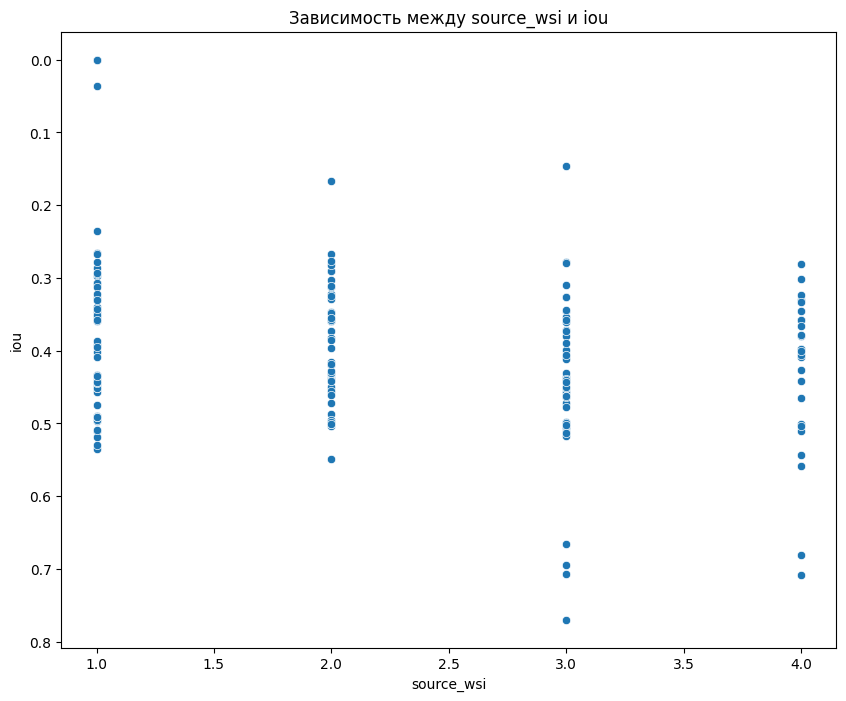

In [261]:
import seaborn as sns
for wsi, subdf in oof.groupby('source_wsi'):
    print(f'wsi {wsi}')
    print(f'IOU mean: {np.mean(subdf.iou.values):.4}')
    print(f'IOU std: {np.std(subdf.iou.values):.4}')
plt.figure(figsize=(10,8))
sns.scatterplot(x='source_wsi', y='iou', data=oof)
plt.title('Зависимость между source_wsi и iou')
plt.show()

wsi 1
IOU mean: 0.3576
IOU std: 0.1361
wsi 2
IOU mean: 0.3614
IOU std: 0.08711
wsi 3
IOU mean: 0.4322
IOU std: 0.1119
wsi 4
IOU mean: 0.4329
IOU std: 0.08676


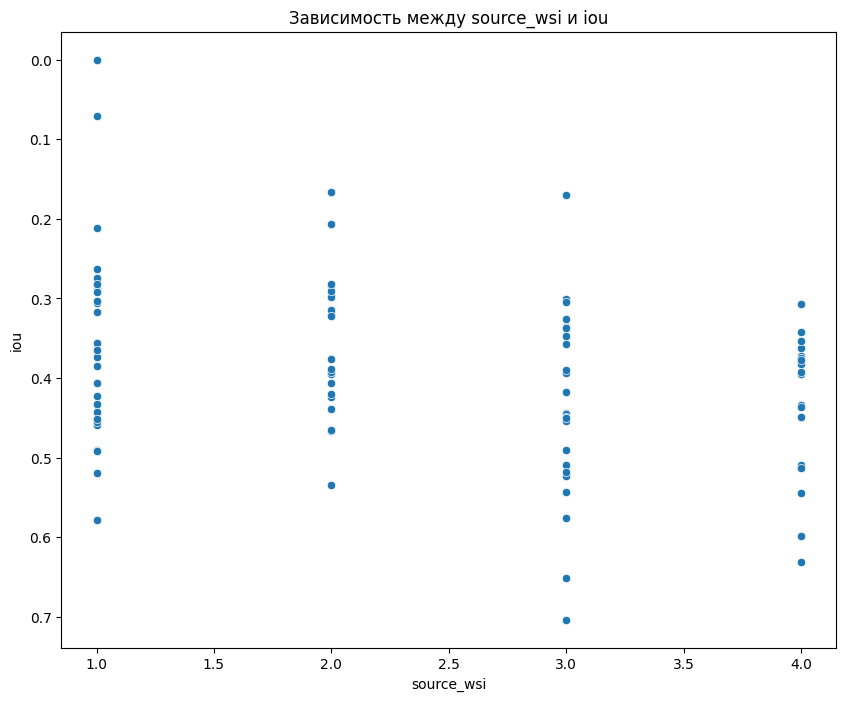

In [184]:
import seaborn as sns
for wsi, subdf in oof.groupby('source_wsi'):
    print(f'wsi {wsi}')
    print(f'IOU mean: {np.mean(subdf.iou.values):.4}')
    print(f'IOU std: {np.std(subdf.iou.values):.4}')
plt.figure(figsize=(10,8))
sns.scatterplot(x='source_wsi', y='iou', data=oof)
plt.title('Зависимость между source_wsi и iou')
plt.show()

In [68]:
FOLDS_ROOT = 'mskf_folds/'
PROJECT = 'HuBMAP'
MODEL_V = 'yolov8x-seg'
PREFIX = 'mskf_'
folds_i = [0, 1, 2]


folds_iou = dict()
for i in folds_i:
    path_to_data = f'{FOLDS_ROOT}/fold{i}/hubmap-coco.yaml'


    model = YOLO(f'{PROJECT}/{PREFIX}{MODEL_V}-fold{i}/weights/best.pt')


    val_dir = f'{FOLDS_ROOT}/fold{i}/valid/'
    val_ids = [r.split('.')[0] for r in os.listdir(val_dir) if r.endswith('.txt')]

    annotations = []
    pred_masks = []
    pred_scores = []
    for image_id in val_ids:
        annotations.append(parse_ann(id_to_annotation[image_id]))
        image = Image.open(os.path.join(val_dir ,image_id+'.tif'))

        raw_boxes, raw_masks, raw_scores = predict(image=image,
                                models=[model],
                                transforms=CFG.transforms,
                                imgsz=CFG.imgsz,
                                conf=CFG.conf,
                                iou_nms=CFG.iou_nms,
                                retina_masks=CFG.retina_masks,
                               )
        if len(raw_boxes) == 0:
            masks = np.zeros((1, *image.size), dtype=np.uint8)
            scores = np.array([0])
        elif CFG.postprocces_type == 'nms':
            masks, scores = combine_results_nmms(raw_boxes, raw_masks, raw_scores, iou_thr=CFG.iou_nms_tta)
        elif CFG.postprocces_type == 'wbf':
            masks, scores = combine_results_wbf(raw_boxes, raw_masks, raw_scores, iou_thr=CFG.iou_nms_tta, label_thr=CFG.wbf_label_thr, cut_by_box=True)
        keep = scores > 0
        masks = masks[keep]
        scores = scores[keep]
        masks = dilate_predict_mask(masks, CFG.dilation_n_iter)
        pred_masks.append(masks)
        pred_scores.append(scores)

    ious = evaluate_model(annotations, pred_masks, pred_scores)
    folds_iou[i] = ious

    print(f'fold {i}')
    print(f'IOU mean: {np.mean(ious):.4}')
    print(f'IOU std: {np.std(ious):.4}')
    print()

print('overall')
print(f'mean {np.mean(sum(folds_iou.values(), [])):.4}')
print(f'std {np.std(sum(folds_iou.values(), [])):.4}')
print(CFG())

fold 0
IOU mean: 0.3946
IOU std: 0.03704

fold 1
IOU mean: 0.45
IOU std: 0.02463

fold 2
IOU mean: 0.4366
IOU std: 0.02719

overall
mean 0.427
std 0.03829
CFG(dilation_n_iter=1, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.6, iou_nms_tta=0.6, wbf_label_thr=0.8, postprocces_type=wbf, min_votes=2, transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False)), stain_norm=1)


In [ ]:
# annotations = []
# pred_masks = []
# pred_scores = []
# for image_id in test_ids[:50]:
#     annotations.append(parse_ann(id_to_annotation[image_id]))
#     image = cv2.imread(f'../data/train/{image_id}.tif')

#     raw_boxes, raw_masks, raw_scores = predict(image=image, # bgr image
#                             models=models,
#                             transforms=CFG.transforms,
#                             # transforms=[None],
#                             imgsz=CFG.imgsz,
#                             conf=CFG.conf,
#                             iou_nms=CFG.iou_nms,
#                             retina_masks=CFG.retina_masks,
#                            )
#     if len(raw_boxes) == 0:
#         masks = np.zeros((1, *image.size), dtype=np.uint8)
#         scores = np.array([0])
#     elif CFG.postprocces_type == 'nms':
#         masks, scores = combine_results_nmms(raw_boxes, raw_masks, raw_scores, iou_thr=CFG.iou_nms_tta)
#     elif CFG.postprocces_type == 'wbf':
#         masks, scores = combine_results_wbf(raw_boxes,raw_masks, raw_scores,
#                                             iou_thr=CFG.iou_nms_tta, min_votes=CFG.min_votes,
#                                             label_thr=CFG.wbf_label_thr)
#     keep = scores > 0
#     masks = masks[keep]
#     scores = scores[keep]
#     masks = dilate_predict_mask(masks, CFG.dilation_n_iter)
#     pred_masks.append(masks)
#     pred_scores.append(scores)

# ious = evaluate_model(annotations, pred_masks, pred_scores)
# print(f'IOU mean: {np.mean(ious):.4}')
# print(f'IOU std: {np.std(ious):.4}')
# print()

In [160]:
image.shape[:2]

(512, 512)

In [ ]:
# fold 0
# IOU mean: 0.5878
# IOU std: 0.03131

# fold 1
# IOU mean: 0.6266
# IOU std: 0.02326

# fold 2
# IOU mean: 0.5871
# IOU std: 0.02105

# fold 3
# IOU mean: 0.6116
# IOU std: 0.02441

# fold 4
# IOU mean: 0.5425
# IOU std: 0.01961

# overall
# mean 0.5911
# std 0.03745
# CFG(dilation_n_iter=1, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.6, iou_nms_tta=0.7, wbf_label_thr=0.7, postprocces_type=wbf, transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False)))

In [90]:
# fold 0
# IOU mean: 0.5271
# IOU std: 0.0332

# fold 1
# IOU mean: 0.5233
# IOU std: 0.02864

# fold 2
# IOU mean: 0.5229
# IOU std: 0.03155

# fold 3
# IOU mean: 0.4992
# IOU std: 0.03389

# fold 4
# IOU mean: 0.5266
# IOU std: 0.03169

# overall
# mean 0.5199
# std 0.03348
# CFG(dilation_n_iter=1, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.6, wbf_label_thr=0.6, postprocces_type=wbf, transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0)))

In [ ]:
# fold 0
# IOU mean: 0.5974
# IOU std: 0.01184

# fold 1
# IOU mean: 0.5942
# IOU std: 0.02097

# fold 2
# IOU mean: 0.5942
# IOU std: 0.01877

# fold 3
# IOU mean: 0.5703
# IOU std: 0.03646

# fold 4
# IOU mean: 0.5905
# IOU std: 0.02505

# overall
# mean 0.5894
# std 0.02586
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.8)

In [ ]:
# fold 0
# IOU mean: 0.512
# IOU std: 0.0288

# fold 1
# IOU mean: 0.485
# IOU std: 0.0254

# fold 2
# IOU mean: 0.479
# IOU std: 0.0229

In [ ]:
print(CFG())

In [ ]:
for i in folds_i:
    print(f'fold {i}')
    print(f'IOU mean: {np.mean(folds_iou[i]):.3}')
    print(f'IOU std: {np.std(folds_iou[i]):.3}')
print('overall')
print(f'mean {np.mean(sum(folds_iou.values(), [])):.3}')
print(f'std {np.std(sum(folds_iou.values(), [])):.3}')

In [ ]:
# CFG(dilation_n_iter=1, conf=0.05,
# imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.3
# fold 0
# IOU mean: 0.5
# IOU std: 0.0275
# fold 1
# IOU mean: 0.485
# IOU std: 0.0296
# fold 2
# IOU mean: 0.477
# IOU std: 0.0284
# fold 3
# IOU mean: 0.441
# IOU std: 0.0327
# fold 4
# IOU mean: 0.468
# IOU std: 0.0276
# overall
# mean 0.474
# std 0.0352

In [ ]:
print()

In [ ]:
raw_masks.shape

In [ ]:
image_id
image = Image.open(os.path.join(val_dir ,image_id+'.tif'))
gt_mask = make_masks(id_to_annotation[image_id])

In [ ]:
imshow(gt_mask)

In [ ]:
image

In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.3, iou_nms_tta=0.3, author=tg @ai_minds, sam_model=sam_l.pt)
# fold 0 IOU mean: 0.5810630028728818
# fold 0 IOU std: 0.01242938740762414
# fold 1 IOU mean: 0.5862236411273175
# fold 1 IOU std: 0.022572651887895537
# fold 2 IOU mean: 0.577123098152969
# fold 2 IOU std: 0.021627394262583248
# fold 3 IOU mean: 0.5526609675078908
# fold 3 IOU std: 0.03596290372500657
# fold 4 IOU mean: 0.5772421264235482
# fold 4 IOU std: 0.02602384296638565

In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.3, iou_nms_tta=0.3, author=tg @ai_minds, sam_model=sam_l.pt)
# fold 0 IOU mean: 0.5810630028728818
# fold 0 IOU std: 0.01242938740762414
# fold 1 IOU mean: 0.5862236411273175
# fold 1 IOU std: 0.022572651887895537
# fold 2 IOU mean: 0.577123098152969
# fold 2 IOU std: 0.021627394262583248
# fold 3 IOU mean: 0.5526609675078908
# fold 3 IOU std: 0.03596290372500657
# fold 4 IOU mean: 0.5772421264235482
# fold 4 IOU std: 0.02602384296638565

In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.7, author=tg @ai_minds)
# fold 0
# IOU mean: 0.5813883380571195
# IOU std: 0.021602333573493074
# fold 1
# IOU mean: 0.5718512034934188
# IOU std: 0.021204994571685447
# fold 2
# IOU mean: 0.577511672296694
# IOU std: 0.01872297097533825
# fold 3
# IOU mean: 0.5571941140070192
# IOU std: 0.03718892123463371
# fold 4
# IOU mean: 0.5767471303179905
# IOU std: 0.031885737575472674

In [ ]:
i = 0
path_to_data = f'{FOLDS_ROOT}/fold{i}/hubmap-coco.yaml'


model = YOLO(f'{PROJECT}/{MODEL_V}-fold{i}/weights/best.pt')


val_dir = f'{FOLDS_ROOT}/fold{i}/valid/'
val_ids = [r.split('.')[0] for r in os.listdir(val_dir) if r.endswith('.txt')]
annotations = [parse_ann(ANN_DICT[image_id]) for image_id in val_ids]
images = [Image.open(os.path.join(val_dir ,image_id+'.tif')) for image_id in val_ids]

In [ ]:
tile_meta = pd.read_csv("../data/tile_meta.csv")

In [ ]:
tile_meta

In [ ]:
for i in folds_i:
    print(f'fold {i}')
    print(f'IOU mean: {np.mean(folds_iou[i])}')
    print(f'IOU std: {np.std(folds_iou[i])}')


In [ ]:
for i in folds_i:
    print(f'fold {i}')
    print(f'IOU mean: {np.mean(folds_iou[i])}')
    print(f'IOU std: {np.std(folds_iou[i])}')


In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.7, author=tg @ai_minds)
# fold 0
# IOU mean: 0.5813883380571195
# IOU std: 0.021602333573493074
# fold 1
# IOU mean: 0.5718512034934188
# IOU std: 0.021204994571685447
# fold 2
# IOU mean: 0.577511672296694
# IOU std: 0.01872297097533825
# fold 3
# IOU mean: 0.5571941140070192
# IOU std: 0.03718892123463371
# fold 4
# IOU mean: 0.5767471303179905
# IOU std: 0.031885737575472674

In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.5, author=tg @ai_minds)
# fold 0
# IOU mean: 0.5814528026638007
# IOU std: 0.01993106164995504
# fold 1
# IOU mean: 0.5742532196320681
# IOU std: 0.021325379354314125
# fold 2
# IOU mean: 0.5681236433177105
# IOU std: 0.017857128449938295
# fold 3
# IOU mean: 0.5616550087820426
# IOU std: 0.04004046646567095
# fold 4
# IOU mean: 0.581137718008946
# IOU std: 0.02790984538510792

In [ ]:
# fold 0
# IOU mean: 0.5814528026638007
# IOU std: 0.01993106164995504
# fold 1
# IOU mean: 0.5742532196320681
# IOU std: 0.021325379354314125
# fold 2
# IOU mean: 0.5681236433177105
# IOU std: 0.017857128449938295
# fold 3
# IOU mean: 0.5616550087820426
# IOU std: 0.04004046646567095
# fold 4
# IOU mean: 0.581137718008946
# IOU std: 0.02790984538510792

In [ ]:
# NO TTA:
# fold 0 IOU mean: 0.5226953892026813
# fold 0 IOU std: 0.029872814532010492

In [ ]:
# WITH TTA:
# fold 0 IOU mean: 0.58
# fold 0 IOU std: 0.019

In [ ]:
#     mosaic=True: Аугментация изображений с помощью объединения нескольких изображений в одно (mosaic augmentation).
#     mixup=0.5: Случайное смешивание изображений для создания новых изображений (mixup augmentation).
#     random_placing=True: Случайное размещение объектов на изображении (random object placing augmentation).
#     hsv_augmentation=True: Изменение цветового пространства изображений (HSV augmentation).
#     degrees=10.0: Вращение изображений на случайный угол (rotation augmentation).
#     translate=0.1: Случайное смещение изображений по горизонтали и вертикали (translation augmentation).
#     scale=0.5: Масштабирование изображений на случайный коэффициент (scale augmentation).
#     shear=2.0: Наклон изображений на случайный угол (shear augmentation).
#     perspective=0.0: Изменение перспективы изображений (perspective augmentation).
#     flipud=0.5: Отражение изображений по вертикали (vertical flip augmentation).
#     fliplr=0.5: Отражение изображений по горизонтали (horizontal flip augmentation).
#     mosaic_scale=[0.5, 1.5]: Масштабирование мозаики изображений на случайный коэффициент.

# INFERENCE

In [ ]:
model = YOLO('HuBMAP/yolov8x-seg10/weights/best.pt')

In [ ]:
DATA_BASE = 'dataset'
BASE_FILENAME = '../data/'

In [ ]:
from skimage.morphology import binary_dilation, binary_closing, binary_opening
from skimage.measure import label, regionprops

def join_masks(masks: np.ndarray):
    """masks in shape n x W x H """
    return np.any(masks, axis=0).astype(int)

def substact_masks(mask1, mask2):
    substraction = mask1 & ~mask2
    if len(substraction) == 0:
        return np.zeros_like(mask1)
    return substraction

def disjoin_mask(mask):
    """mask in shape W x H"""
    if not np.any(mask):
        return mask[None, :, :]
    labeled_mask = label(mask)  # Результат - маска, где каждый объект имеет уникальное число
    props = regionprops(labeled_mask)

    new_masks = []
    for prop in props:
        new_mask = np.zeros_like(mask)
        new_mask[labeled_mask == prop.label] = 1
        new_masks.append(new_mask)

    new_masks_array = np.array(new_masks)
    return new_masks_array

def dilate_predict_mask(mask, n_iter=1):
    for i in range(len(mask)):
        for _ in range(n_iter):
            mask[i] = binary_dilation(mask[i])
    return mask

In [ ]:
val_dir = f"{DATA_BASE}/val"
val_ids = [r.split('.')[0] for r in os.listdir(val_dir+'/labels')]

In [ ]:
with open(f'{BASE_FILENAME}/polygons.jsonl', 'r') as json_file:
    json_labels = [json.loads(line) for line in json_file]

In [ ]:
ann_dict = {j['id']: j['annotations'] for j in json_labels}

In [ ]:
from skimage.morphology import binary_dilation, binary_closing, binary_opening

def dilate_predict_mask(mask, n_iter=1):
    for i in range(len(mask)):
        for _ in range(n_iter):
            mask[i] = binary_dilation(mask[i])
    return mask

In [ ]:
import cv2

def dilate_predict_mask_cv(mask, n_iter=1):
    kernel = np.ones(shape=(3, 3), dtype=np.uint8)
    for i in range(len(mask)):
        mask[i] = cv2.dilate(mask[i].astype(np.uint8), kernel, 1, iterations=n_iter)
    return mask